In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks, montage
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score, mean_squared_error
from PIL import Image
import glob

In [3]:
image_dir = ".\\Stimulus presentation script\\stimuli"
files     = glob.glob(image_dir + "\\*.jpg")
filenames = [file.split("\\")[-1] for file in files]
images    = np.stack([np.array(Image.open(file).convert("L")) for file in files])
means     = np.mean(images, axis=0)

In [4]:
zero_mean_images = (images - means).reshape(300,-1)

N_COMPONENTS = None # Get all of them
pca = PCA(n_components=N_COMPONENTS)
S = pca.fit_transform( zero_mean_images )
A = pca.components_
reconstruction = S @ A

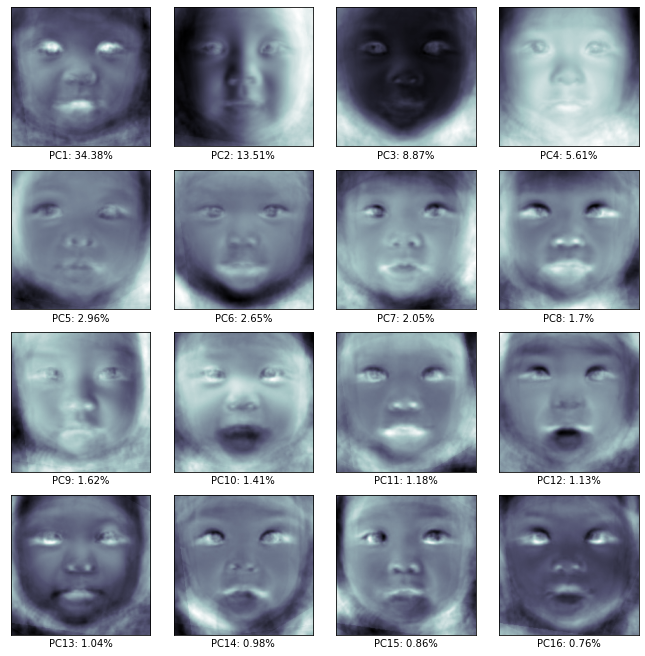

In [5]:
A_img = A.reshape(300, 200, 200)
fig, ax = plt.subplots(4, 4, figsize=(9,9), constrained_layout=True)
for i in range(0,4):
    for j in range(0,4):
        ax[i,j].imshow( A_img[i * 4 + j]*pca.explained_variance_[i*4+j] + means , cmap="bone")
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xlabel(f"PC{i*4+j+1}: {round(pca.explained_variance_ratio_[i*4+j]*100,2)}%")
        #ax[i,j].set_axis_off()
plt.savefig("ugly babies.png")
plt.show()


In [6]:
cidx = pd.read_csv("cidx_avg.csv", index_col="filename")

In [10]:
# Greedy forward feature selection
tolerance = 0.001
features = np.full((300), False)
y = cidx.loc[filenames]


old_score = np.inf
for i in range(300):
    # Keep track of scores
    scores = np.full((300), np.inf)
    for i in range(len(features)):
        if features[i]: # Already selected
            continue
        # Temporarily enable
        features[i] = True

        comps = pca.components_[features]
        X = zero_mean_images @ comps.T
        # Fit regression
        lr = LinearRegression()
        lr.fit(X, y)
        scores[i] = mean_squared_error(lr.predict(X),y)

        # Disable again
        features[i] = False
    # Enable lowest MSE-score component
    min_score = scores.min()
    if min_score + tolerance < old_score:
        print(min_score)
        features[scores.argmin()] = True
        old_score = min_score
    else:
        break
    

0.4302340644190353
0.4071459893189398
0.3848095388064765
0.3636681804063178
0.3465168559927061
0.33050383128925925
0.3160269474952306
0.30271289494982623
0.2901080640593318
0.277923750684715
0.2659751621707043
0.25505855406926015
0.24506538671811048
0.23721405054750042
0.22990030746349352
0.2226895406232985
0.21682006461300413
0.2110945650394505
0.20537974065269704
0.19968184706044506
0.19414746615705358
0.1890094204771193
0.18408493222893238
0.1792398809534173
0.17440514446839878
0.1697121693226498
0.1652170017314351
0.1610825820907271
0.15702613797442155
0.1531152101551056
0.14938014690390877
0.14597148619452657
0.14257900405591237
0.13940647797070171
0.13635111893939672
0.1333747444786656
0.13045770173665333
0.12759545620622045
0.1247362596616981
0.12191403037479555
0.1193083860638877
0.11674952351415269
0.11423510138357389
0.1117751207257931
0.10937500681395884
0.10699933189145085
0.10483139383400653
0.10267513403628913
0.10060975723740587
0.09860803573282464
0.09661783656533908
0.

In [19]:
np.argwhere(features).shape

(82, 1)

In [29]:
comps = pca.components_[features]
X = zero_mean_images @ comps.T
lr = LinearRegression()
lr.fit(X, y)
B = lr.coef_
d = lr.intercept_